<a href="https://colab.research.google.com/github/Xavi990/ML_hotel_bookings/blob/master/DatasetPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook para preprocesar el dataset. Se realizan todas las transformaciones necesarias**

In [2]:
# Se cargan los archivos dataset originales

from google.colab import files
uploaded=files.upload()

Saving hotel_bookings.csv to hotel_bookings.csv


In [0]:
# Rutas de los archivos 
local_base_path = ""
original_dataset_url = local_base_path + "hotel_bookings.csv"
countries_dataset_url = local_base_path + "country-and-continent-codes-list.csv"

preprocessed_dataset_url_con_dup = local_base_path + "hotel_bookings_preprocessed_dup.csv"
preprocessed_dataset_url_sin_dup = local_base_path + "hotel_bookings_preprocessed_nodup.csv"

# Librerias necesarias
import pandas
import datetime

In [0]:
# Funcion que facilita la conversion de variables dummies dentro de un dataframe

def addDummiesInDataFrame(df_aux, attribute, namePrefix):
    dummy_attribute = pandas.get_dummies(df_aux[attribute].apply(lambda x: namePrefix + str(x)))
    df_aux = df_aux.merge(dummy_attribute, left_index=True, right_index=True)
    df_aux.drop([attribute], axis=1, inplace=True)
    return df_aux

**Funciones para el manejo de valores fecha**



In [0]:
# Calculos con fechas y conversion de variables
def mapDateAttributes(df):
    # Se crea una nueva columna con la fecha arrival_date en datetime
    df['arrival_date'] = df.apply(get_date, axis = 1)

    # Se quitan del dataset las columnas arrival date que vienen particionadas
    df.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'arrival_date_week_number'], axis=1, inplace=True)

    # Se calcula la cantidad de dias en la que se produce el cancelamiento respecto a la fecha esperada de arrival
    #df['cancel_days_before_arrival'] = df.apply(calcula_dias_anticipo_cancelamiento, axis=1)

    # Se crean columnas dummies para los meses de arrival_date
    # Estas pueden servir para establecer temporadas de tendencias, como ser el pais de origen, los
    df['arrival_month'] = df['arrival_date'].apply(lambda x: str(x.month))
    df = addDummiesInDataFrame(df, 'arrival_month', 'arrival_month_')

    # eliminar la variables reservation_status_date
    df.drop(['arrival_date', 'reservation_status_date'], axis=1, inplace=True)

    return df

# Funcion que toma el mes en nombre y devuelve el numero de mes calendario entre 1 y 12
def get_month_num(month_name):
    month_dicc = \
        {'January': 1,
        'February': 2,
        'March': 3,
        'April': 4,
        'May': 5,
        'June': 6,
        'July': 7,
        'August': 8,
        'September': 9,
        'October': 10,
        'November': 11,
        'December': 12}
    return month_dicc[month_name]

# Funcion que toma la tres componentes de la fecha segun dataset en uso y devuelve la fecha en datetime.
def get_date(df):
    return datetime.datetime( \
        int(df['arrival_date_year']),
        int(get_month_num(df['arrival_date_month'])), \
        int(df['arrival_date_day_of_month']))

def calcula_dias_anticipo_cancelamiento(df):
    # TODO revisar si este campo
    if df['is_canceled'] == 1:
        return (df['arrival_date'] - df['reservation_status_date']).days
    else:
        return 0

**Funciones para manejo de valores de paises**

In [0]:
# Lee dataset de definiciones de paises
def getCountries(countries_dataset_url):
    countries_df = pandas.read_csv(countries_dataset_url)
    return countries_df

# Merge de paises con dataset booking. Luego variables dummies por continente
def mapCountryAtributes(countries_dataset_url, df):
    # Levanta el dataset de definicion de countries y lo agrega al df booking de acuerdo al country code.
    countryDF = getCountries(countries_dataset_url)
    df = df.merge(countryDF, how='left', left_on='country', right_on='Three_Letter_Country_Code', suffixes=(False, False))

    # se reemplazan los valores nulos por la moda 'Europe'
    continente_moda = df['Continent_Name'].mode()
    df['Continent_Name'].fillna(continente_moda[0], inplace=True)
    
    # Convierte la variables countries en dummies
    df = addDummiesInDataFrame(df, 'Continent_Name', 'continent_')

    df.drop(['Continent_Code', 'Country_Name', 'Two_Letter_Country_Code', 'Three_Letter_Country_Code', 'Country_Number'], axis=1, inplace=True)

    # Se elimina la columna country
    df.drop(['country'], axis=1, inplace=True)

    return df

In [0]:
# Funcion que levanta los dataset y preprocesa

def LoadAndPreprocessDataFrame(original_dataset_url, countries_dataset_url):
    # Carga del dataset original
    booking_dataset = pandas.read_csv(original_dataset_url, parse_dates=['reservation_status_date'])

    # Se ajustan las variables fecha del dataset
    booking_dataset = mapDateAttributes(booking_dataset)

    # Se ajustan los atributos country
    booking_dataset = mapCountryAtributes(countries_dataset_url, booking_dataset)

    # Se convierte en variable binaria el atributo agent
    booking_dataset['agent'].fillna(0, inplace=True)
    booking_dataset['agent_b'] = booking_dataset['agent'].apply(lambda x: 1 if x > 0 else 0)
    booking_dataset.drop(['agent'], axis=1, inplace=True)

    # Se convierte en variable binaria el atributo company
    booking_dataset['company'].fillna(0, inplace=True)
    booking_dataset['company_b'] = booking_dataset['company'].apply(lambda x: 1 if x > 0 else 0)
    booking_dataset.drop(['company'], axis=1, inplace=True)
    
     ## Manejo de valores faltantes 
    
    # variable children 4 registros null
    # lo reemplazamos por cero
    booking_dataset['children'].fillna(0, inplace=True)
    
    # variables con valores undefined
    # variable meal, reemplazo por la moda
    meal_moda= booking_dataset.meal.mode()
    booking_dataset['meal'] = booking_dataset['meal'].apply(lambda x: meal_moda[0] if x =="Undefined" else x)
 
    #variable market segment, reemplazo con la moda
    market_segment_moda= booking_dataset.market_segment.mode()
    booking_dataset['market_segment'] = booking_dataset['market_segment'].apply(lambda x: market_segment_moda[0] if x =="Undefined" else x)

    #variable ditribution_channel, reemplazo con la moda
    ditribution_channel_moda= booking_dataset.distribution_channel.mode()
    booking_dataset['distribution_channel'] = booking_dataset['distribution_channel'].apply(lambda x: ditribution_channel_moda[0] if x =="Undefined" else x)
    
    ## fin valores faltantes
    
    # Se convierte a variables dummies
    booking_dataset = addDummiesInDataFrame(booking_dataset, 'meal', 'meal_')
    booking_dataset = addDummiesInDataFrame(booking_dataset, 'market_segment', 'market_seg_')
    booking_dataset = addDummiesInDataFrame(booking_dataset, 'distribution_channel', 'dist_channel_')
    booking_dataset = addDummiesInDataFrame(booking_dataset, 'deposit_type', 'deposit_')
    booking_dataset = addDummiesInDataFrame(booking_dataset, 'customer_type', 'cust_type_')
    
    ## outliers de adr
    
    # ver qué asignamos a los outliers o valores que no tienen sentido???
    # habria que ver si lo queremos hacer y si sirve lo que hice abajo
    # pongo cero a los que serían valores incorrectos, por ser menores a 1 y mayor a 5000 
    # y luego los reemplazo por la media
    booking_dataset['adr'] = booking_dataset['adr'].apply(lambda x: 0 if x < 1 or x > 5000 else x)
    mean_adr = booking_dataset.adr.mean()
    booking_dataset['adr'] = booking_dataset['adr'].apply(lambda x: mean_adr if x == 0 else x)
    
    ## fin outliers adr

    # Variable adr se calcula la relacion por huesped. Los menores se los consiera a la mitad. Los babies no se toman para el calculo
    booking_dataset['adr_por_persona'] = booking_dataset.apply(lambda x: float(x['adr']) / (float(x['adults']) + 0.5 * float(x['children'])) if (float(x['adults']) + 0.5 * float(x['children'])) > 0 else 0, axis=1)

    # Eliminacion de columnas
    # Se elimina variable 'hotel' para permitir generalizar para otros hoteles, no especificamente los del dataset
    # Se elimina variable 'reservation_status' por no ser una variable de entrada, sino una de salida a predecir compatible con 'is_canceled'
    # Se eliminan las variables 'reserved_room_type' y 'assigned_room_type' por no tener en claro que significa cada categoria,
    #   si son categoricas ordinales, o sin simplemente ID. Tampoco si el huespues conoce el valor de 'assigned_room_type'
    #   antes del check in
    booking_dataset.drop(['hotel', 'reservation_status', 'reserved_room_type', 'assigned_room_type'], axis=1, inplace=True)

    return booking_dataset

**Se ejecuta el preprocesamiento. Se compara los distintos balanceos con y sin eliminacion de duplicados**

In [0]:
# Se ejecuta el preprocesamiento del dataset
booking_dataset_con_dup = LoadAndPreprocessDataFrame(original_dataset_url, countries_dataset_url)

# Se elimina duplicados
booking_dataset_sin_dup = booking_dataset_con_dup.drop_duplicates(keep=False)

# Se calcula el desbalanceo entre clases antes y despues de eliminar duplicados
con_duplicados = booking_dataset_con_dup['is_canceled'].value_counts()
sin_duplicados = booking_dataset_sin_dup['is_canceled'].value_counts()
con_duplicados_perc = booking_dataset_con_dup['is_canceled'].value_counts(normalize=True)
sin_duplicados_perc = booking_dataset_sin_dup['is_canceled'].value_counts(normalize=True)


Visualizacion del desbalanceo en cantidades abosultas

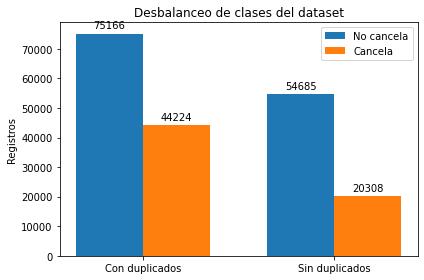

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['Con duplicados', 'Sin duplicados']
no_cancela = [con_duplicados[0], sin_duplicados[0]]
cancela = [con_duplicados[1], sin_duplicados[1]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, no_cancela, width, label='No cancela')
rects2 = ax.bar(x + width/2, cancela, width, label='Cancela')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Registros')
ax.set_title('Desbalanceo de clases del dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

Visualizacion del desbalanceo porcentual

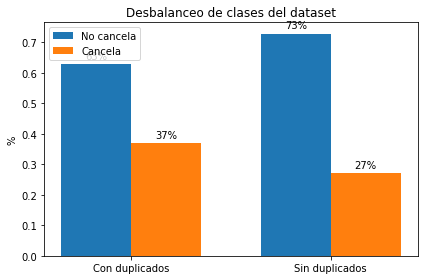

In [17]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['Con duplicados', 'Sin duplicados']
no_cancela = [con_duplicados_perc[0], sin_duplicados_perc[0]]
cancela = [con_duplicados_perc[1], sin_duplicados_perc[1]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, no_cancela, width, label='No cancela')
rects2 = ax.bar(x + width/2, cancela, width, label='Cancela')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('%')
ax.set_title('Desbalanceo de clases del dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.0%}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

**Se almacena el dataset para futuros usos**

In [0]:
# Se guarda el dataset procesado con y sin duplicados
booking_dataset_con_dup.to_csv(preprocessed_dataset_url_con_dup, sep=',', encoding='utf-8')
booking_dataset_sin_dup.to_csv(preprocessed_dataset_url_sin_dup, sep=',', encoding='utf-8')
